### K-Means Clustering on soil data from Pueblo County, Colorado

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pyarrow

# Importing libraries for KMeans and Heirarchical Clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Reading dataset
df = pd.read_parquet('pueblo_pca.parquet')
df.head()

,date,precip,max_temp,min_temp,gwl,sm_20cm,st_20cm,sm_50cm,st_50cm,sm_100cm,st_100cm,daily_discharge_cfs,sm_pca,st_pca
0,2010-02-14,0.0,36,13,20.52,0.205500,0.408333,0.182875,1.320833,0.135333,3.700000,136.0,3.619512,0.190574
1,2010-02-15,0.0,41,7,20.51,0.215333,0.595833,0.183292,1.445833,0.137250,3.625000,129.0,3.470118,0.209177
2,2010-02-16,0.0,43,8,20.51,0.210417,0.500000,0.183625,1.495833,0.136583,3.700000,130.0,3.433721,0.197542
3,2010-02-17,0.0,51,10,20.51,0.209708,0.500000,0.184667,1.437500,0.135625,3.645833,132.0,3.351107,0.135033
4,2010-02-18,0.0,51,16,20.50,0.210542,0.637500,0.185125,1.479167,0.135333,3.708333,135.0,3.238121,0.107690


&emsp; ***Filtering and Cleaning***


To begin, I'll create a standardized (with no NaN values) dataset, which contains contains data for: 

* Precipitation (precip)
* Maximum Temperature (max_temp)
* Minimum Temperature (min_temp)
* Groundwater Level (gwl)
* Daily Discharge (daily_discharge_cfs)
* Soil Moisture Principal Component Analysis (sm_pca)
* Soil Temperature Principal Component Analysis (st_pca)

In [3]:
features = ['precip','max_temp','min_temp','gwl','daily_discharge_cfs','sm_pca','st_pca']
X = df[features]
print(X.shape)

# Remove NaN values
X = X.dropna()

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert the result back to a DataFrame
X = pd.DataFrame(X, columns=features)

# Check the shape of the standardized DataFrame
print(X.shape)

(4881, 7)
(4718, 7)


&emsp; ***K-Means Applied - Elbow Plot***

Now I'll be performing KMeans clustering with upto 20 clusters and plotting the elbow plot with wcss

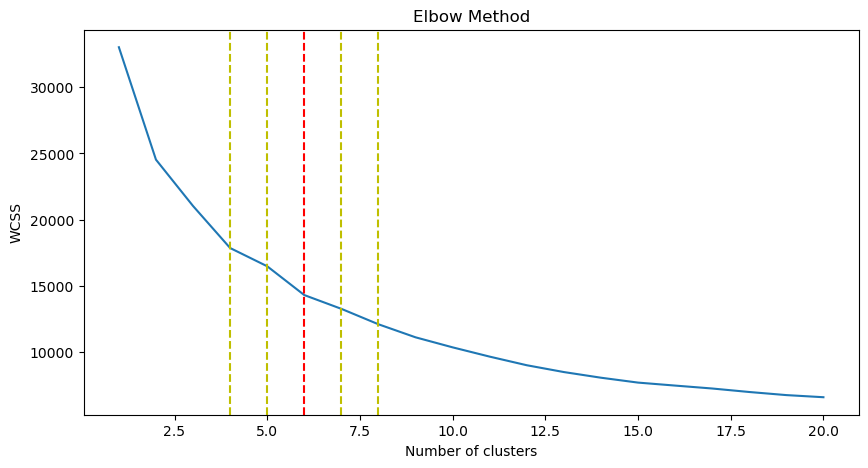

In [4]:
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)  # Fit the model to the data
    wcss.append(kmeans.inertia_)  # Append the WCSS value (inertia) for the current number of clusters
# Plotting the elbow plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), wcss)

# Add dashed line at 5,6,7,8 clusters
plt.axvline(x=4, color='y', linestyle='--')
plt.axvline(x=5, color='y', linestyle='--')
plt.axvline(x=6, color='r', linestyle='--')
plt.axvline(x=7, color='y', linestyle='--')
plt.axvline(x=8, color='y', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

&emsp; ***K-Means Applied -Silhoutte Score***


The **Silhouette Score** is a metric used to evaluate the quality of clustering results. It provides a measure of how similar an object is to its own cluster compared to other clusters. The score ranges from **-1 to 1**, where:

- **1** indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters.
- **0** indicates that the object lies on the boundary between two clusters.
- **-1** indicates that the object may have been assigned to the wrong cluster.

&emsp; ***Practical Usage***

The Silhouette Score is often used to:

1. Compare the quality of clustering results for different numbers of clusters (\( k \)).
2. Select the optimal number of clusters (\( k \)) by choosing the value that maximizes the Silhouette Score.


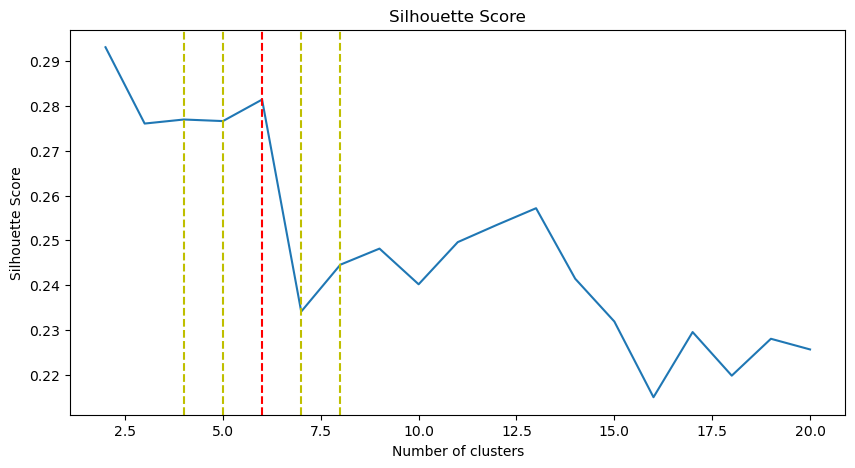

In [5]:

silhouette_score_list = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    labels = kmeans.fit_predict(X)  # Get cluster labels for the data
    score = silhouette_score(X, labels)  # Calculate the silhouette score
    silhouette_score_list.append(score)  # Append the score to the list
    
# Plotting the silhouette score
plt.figure(figsize=(10, 5))
plt.plot(range(2, 21), silhouette_score_list)

# Add dashed line at 5,6,7,8 clusters
plt.axvline(x=4, color='y', linestyle='--')
plt.axvline(x=5, color='y', linestyle='--')
plt.axvline(x=6, color='r', linestyle='--')
plt.axvline(x=7, color='y', linestyle='--')
plt.axvline(x=8, color='y', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

&emsp; ***Optimal number of clusters***


Based on the Elbow plot of WCSS and Silhouette score, we can see that the rate of drop in WCSS decreases after 6 clusters i.e after red dashed line. Hence, we can conclude that 6 clusters are optimal for our data. Next, I'll create parallel plots to visualize the clusters centroids

In [6]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# Adding cluster labels to the dataframe
df_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
df_centroids['cluster'] = df_centroids.index

fig = px.parallel_coordinates(df_centroids, color='cluster', color_continuous_scale=px.colors.sequential.Viridis)
fig.show()

&emsp; ***Meaning of the parallel coords. plot***


From the plot we can see that: 

Cluster Profiles - Each line represents a cluster centroid, and its position along each axis shows the average value of that cluster for the corresponding feature. For instance, the "precip" axis shows how much the average precipitation differs among clusters.

Feature Influence - The variation in the lines across an axis indicates how influential that feature is in differentiating clusters. For example, if the lines diverge widely at a specific axis, that feature contributes significantly to distinguishing the clusters.

Cluster Comparison - By observing the patterns of the lines, you can compare clusters. For example, some clusters might have high values for "precip" but low values for "gwl" or "daily_discharge_cfs" and clusters that show little deviation across all axes might represent groups with less distinct characteristics.

Finally, I'll perform a hierarchical clustering

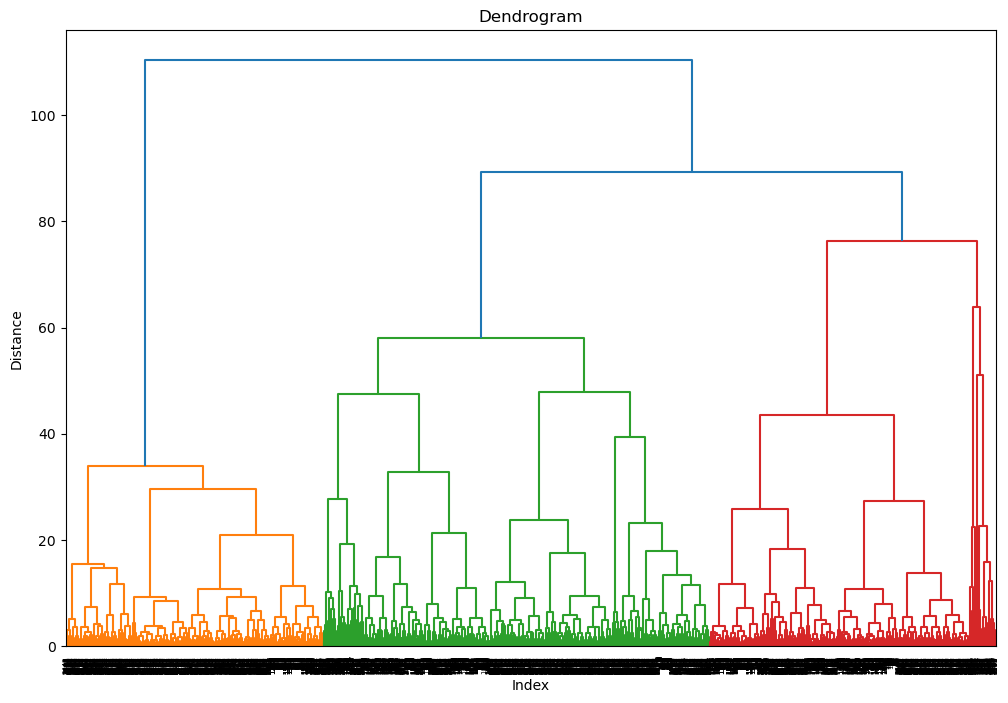

In [7]:
# Performing Heirarchical clustering and plotting the dendrogram

Z = linkage(X, 'ward')

plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

The dendrogram is a tree-like diagram that represents the hierarchical clustering of your data. It helps you understand how data points are grouped together based on their similarity.

The key components are the x axis which represents the data points or observations. The labels are often omitted or condensed if there are many data points; The y axis represents the distance or dissimilarity between clusters. The height at which two clusters are merged reflects their dissimilarity and each branch represents a cluster. As you move up, branches merge into larger clusters.